In [1]:
import os
os.chdir("..")

In [2]:
from commons.api.utils import set_to_our_gpus, enable_web_access
set_to_our_gpus()
enable_web_access()

In [3]:
from juneja.validation_pipeline.preprocess import img_to_tensor
from juneja.validation_pipeline.metrics import normalize, match_hist, normalize_map, SIM, CC, NSS
from api.metrics import apply_grey_patch, add_random_noise_to_image
# from juneja.validation_pipeline.inference import generate_saliency

from commons.api.imagenet_tiny import get_imagenet_classes, get_random_images

from commons.ScoreCAM.cam import CAM, GradCAM, GradCAMpp, SmoothGradCAMpp, ScoreCAM
from commons.ScoreCAM.utils.visualize import visualize, reverse_normalize
from commons.ScoreCAM.utils.imagenet_labels import label2idx, idx2label

from shardul.api.viz import visualize_saliency_overlay

In [4]:
import matplotlib
import matplotlib.gridspec as gridspec


from PIL import Image
from numpy import random
import random
import torch
import numpy as np
import matplotlib.pyplot as plt
import skimage.transform
import torch
import torch.nn as nn
import torch.nn.functional as F
from scipy.spatial.distance import cdist
from pyemd import emd
import tensorflow as tf
from cv2 import EMD
from captum.attr import LayerAttribution, LayerGradCam
from captum.attr import visualization as viz
import cv2
# from ScoreCAM import cam

from PIL import Image
from matplotlib.pyplot import imshow
from torchvision import models, transforms
from torchvision.utils import save_image

2023-10-25 02:26:46.108537: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-25 02:26:51.156823: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /scratch/smitra/python/lib/python3.8/site-packages/cv2/../../lib64:/usr/local/cuda-11.3/lib64:/scratch/smitra/python/lib:/usr/local/cuda-11.3/tensorRT-8.0/lib64:/usr/local/cuda-11.3/cudnn-8.2/lib64:/usr/local/cuda-11.3/nccl-2.9/lib64
2023-10-25 02:26:51.157219: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7

In [188]:
!nvidia-smi

Wed Oct 25 03:10:20 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.86.10              Driver Version: 535.86.10    CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 2080 Ti     Off | 00000000:B1:00.0 Off |                  N/A |
| 31%   54C    P2              78W / 250W |    807MiB / 11264MiB |     37%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

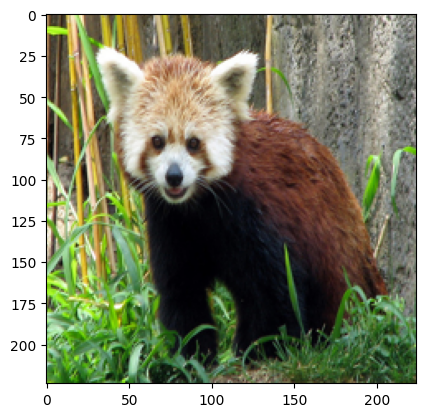

In [135]:
# image_path = "/project/validating_attribution_techniques/commons/examples/input.png"
# img = Image.open(image_path)
img = Image.fromarray(images[0])
imshow(img)
# image = Image.open('/project/validating_attribution_techniques/commons/examples/input.png')

In [136]:
def preprocessing(image):
    # Resize the image
    size = (300, 300)
    image = image.resize(size)
    
    # preprocessing. mean and std from ImageNet
    normalize = transforms.Normalize(
       mean=[0.485, 0.456, 0.406],
       std=[0.229, 0.224, 0.225]
    )

    preprocess = transforms.Compose([
        transforms.ToTensor(),
        normalize
    ])

    # convert image to tensor
    tensor = preprocess(image)

    # reshape 4D tensor (N, C, H, W)
    tensor = tensor.unsqueeze(0)
    
    return tensor

In [137]:
tensor = preprocessing(img)

In [138]:
tensor.shape

torch.Size([1, 3, 300, 300])

In [139]:

tensor_gpu_grad = tensor.clone()
tensor_gpu_score = tensor.detach()
tensor_gpu_gradpp = tensor.clone()

In [140]:

use_cuda = True
device = torch.device("cuda" if use_cuda else "cpu")
model_gpu = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', pretrained=True).to(device)
# model_cpu = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', pretrained=True)
model_gpu.eval()

Using cache found in /home/smitra/.cache/torch/hub/pytorch_vision_v0.10.0


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [141]:
gpu_reference_tensor = next(model_gpu.parameters())
tensor_gpu_grad = tensor_gpu_grad.type_as(gpu_reference_tensor)
tensor_gpu_gradpp = tensor_gpu_gradpp.type_as(gpu_reference_tensor)
tensor_gpu_score = tensor_gpu_score.type_as(gpu_reference_tensor)

tensors = [tensor_gpu_grad, tensor_gpu_score, tensor_gpu_gradpp]

In [142]:
def saliency_map(tensor, cam):
#     tensor = tensor.cpu()
    img = reverse_normalize(tensor)
#     img = img.detach().cpu().numpy()
    heatmap = visualize(img, cam)
    heatmap_saliency = np.transpose(heatmap.squeeze(), (1, 2, 0))
    return heatmap_saliency

In [143]:
target_layer = model_gpu.layer4[1].conv2
classes = open("/project/validating_attribution_techniques/shardul/classes.txt").read().splitlines()

In [144]:
def scoreCAM(target_layer, model, tensor):
    wrapped_model = ScoreCAM(model, target_layer)
    cam, idx = wrapped_model(tensor)
    return cam, idx

In [145]:
def gradCAM(target_layer, model, tensor):
    wrapped_model = GradCAM(model, target_layer)
    cam, idx = wrapped_model(tensor)
    return cam, idx

In [146]:
def gradpp(target_layer, model, tensor):
    # Create an instance of SmoothGradCAMpp
    wrapped_model = GradCAMpp(model, target_layer)
    # Call GradCAMpp without the tensor argument
    cam, idx = wrapped_model(tensor)
    
    return cam, idx


In [147]:
def saliency_map(tensor, cam):
#     tensor = tensor.cpu()
    img = reverse_normalize(tensor)
    heatmap = visualize(img, cam)
    heatmap_saliency = np.transpose(heatmap.squeeze(), (1, 2, 0))
    return heatmap_saliency

In [164]:
Gradcam, grad_idx = gradCAM(target_layer, model_gpu, tensor_gpu_grad)
Gradcam = Gradcam.cpu()

predicted class ids 387	 probability 0.9458941221237183


In [165]:
scorecam, score_idx = scoreCAM(target_layer, model_gpu, tensor_gpu_score)
scorecam = scorecam.cpu()

In [166]:
# Gradcampp, gradpp_idx = gradpp(target_layer, model_gpu, tensor_gpu_gradpp)
# Gradcampp = Gradcampp.cpu()

In [185]:
heatmaps = [Gradcam, scorecam]
labels = [grad_idx, score_idx]
methods = ["GradCAM", "ScoreCAM"]

In [186]:
print(Gradcam.shape)
# print(heatmaps[0].shape)

torch.Size([1, 1, 10, 10])


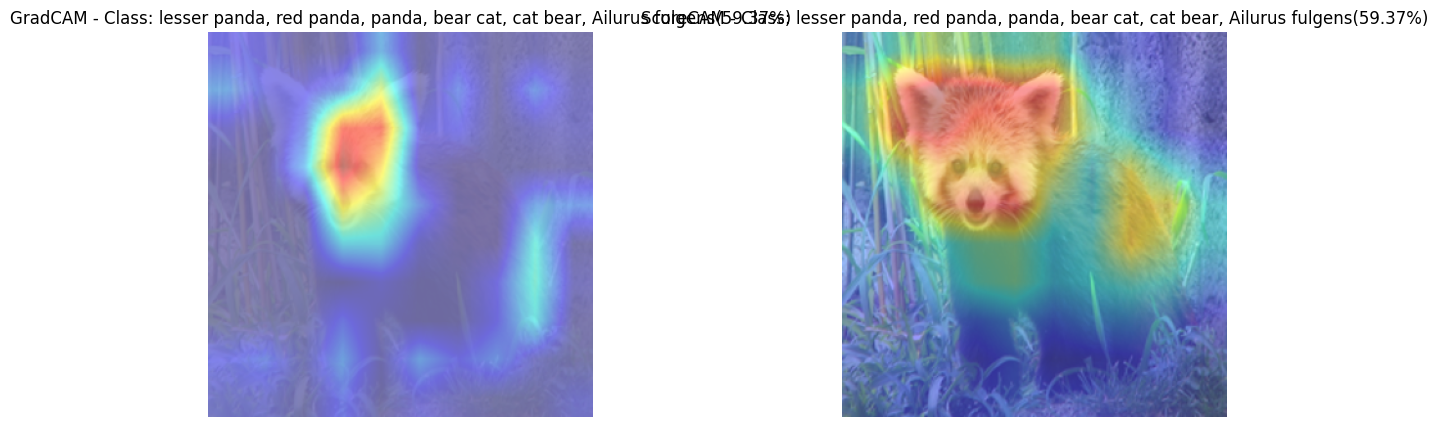

In [187]:
fig, ax = plt.subplots(1, 2, figsize = (15, 5))
with torch.no_grad():
  output_grad = model_gpu(tensor_gpu_grad)
  class_grad = torch.argmax(output_grad).item()
  prob_grad = torch.softmax(output_grad, dim=1)[0, class_grad].item()

for i in range(len(heatmaps)):
    heatmap = saliency_map(tensors[i], heatmaps[i])
    ax[i].imshow(heatmap, cmap='turbo', alpha=0.8)
    ax[i].set_title(f"{methods[i]} - Class: {idx2label[labels[i]]}({prob_grad*100:.2f}%)")
    ax[i].axis('off')  # Turn off the axis
fig.show()
fig.savefig("/project/validating_attribution_techniques/shardul/NSS/Initial.png")


In [25]:
print(type(heatmap))
print(heatmap.shape)

<class 'torch.Tensor'>
torch.Size([300, 300, 3])


In [23]:
dir_path = "/home/shkulkar/project/validating_attribution_techniques/shardul/output/noisy_images/occlusion/"
count = 0
# Iterate directory
for path in os.listdir(dir_path):
    # check if current path is a file
    if os.path.isfile(os.path.join(dir_path, path)):
        count += 1
print('File count:', count)

File count: 16


In [14]:
def wasserstein_distance(cam, perturbed_cam, method):
    # Ensure that the tensors have the same shape
    if method == "GradCAM":
        emd = EMD(np.reshape(cam.numpy(),(10,10)), np.reshape(perturbed_cam.numpy(),(10,10)), 1)
        return emd[0]
    elif method == "ScoreCAM":
        emd = EMD(np.reshape(cam.numpy(),(300,300)), np.reshape(perturbed_cam.numpy(),(300,300)), 1)
        return emd[0]
    elif method == "GradCAMpp":
        cam = np.where(cam > 0, cam, 1e-5)
        perturbed_cam = np.where(perturbed_cam > 0, perturbed_cam, 1e-5)
        emd = EMD(np.reshape(cam, (10, 10)), np.reshape(perturbed_cam, (10, 10)), 1)
        return emd[0]


In [15]:
def calculate_metrics(cam, perturbed_cam, method):
    sim = SIM(cam, perturbed_cam)
    cc = CC(cam, perturbed_cam)
    nss = NSS(cam, perturbed_cam)
#     auc_judd = AUC_Judd(cam, perturbed_cam)
#     auc_borji = AUC_Borji(cam, perturbed_cam)
    emd = wasserstein_distance(cam, perturbed_cam, method)
    return sim, cc, nss, emd

# 16 perturbed images analysis using GradCAM, ScoreCAM, GradCAM++

In [48]:

gradcam_saliencies = []
scorecam_saliencies = []
# gradcampp_saliencies = []

fig, ax = plt.subplots(count, 2,figsize=(6, 2* count))
fig.subplots_adjust(hspace=1.5)  # Increase the vertical gap between rows
fig.suptitle("GradCAM vs ScoreCAM vs GradCAM++", fontsize=16, fontweight="bold", y = 1.0)
fig.set_figwidth(12)
# fig.set_layout_engine('tight')
fig.set_figheight(80)

# Create a gridspec for the subplots
gs = gridspec.GridSpec(count, 2)

for i in range(count):
    # Create a new figure for each iteration

    # Load the image using PIL
    img_path = "/home/shkulkar/project/validating_attribution_techniques/shardul/output/noisy_images/occlusion/occluded_img_" + str(i) + ".jpg"
    img = Image.open(img_path)

    perturbed_tensor_grad = preprocessing(img)  # calling the preprocessing function
    perturbed_tensor_score = preprocessing(img)  # calling the preprocessing function
#     perturbed_tensor_gradpp = preprocessing(img)

    gpu_reference_tensor = next(model_gpu.parameters())
    perturbed_tensor_grad = perturbed_tensor_grad.type_as(gpu_reference_tensor)
    perturbed_tensor_score = perturbed_tensor_score.type_as(gpu_reference_tensor)
#     perturbed_tensor_gradpp = perturbed_tensor_gradpp.type_as(gpu_reference_tensor)

    perturbed_gradcam, perturbed_grad_idx = gradCAM(target_layer, model_gpu, perturbed_tensor_grad)
    perturbed_scorecam, perturbed_score_idx = scoreCAM(target_layer, model_gpu, perturbed_tensor_score)
#     perturbed_gradcampp, perturbed_gradpp_idx = gradpp(target_layer, model_gpu, perturbed_tensor_gradpp)

    perturbed_gradcam = perturbed_gradcam.cpu()
    perturbed_scorecam = perturbed_scorecam.cpu()
#     perturbed_gradcampp = perturbed_gradcampp.cpu()

    sim_grad, cc_grad, nss_grad, emd_grad = calculate_metrics(Gradcam, perturbed_gradcam, "GradCAM")
    sim_score, cc_score, nss_score, emd_score = calculate_metrics(scorecam, perturbed_scorecam, "ScoreCAM")
#     sim_gradpp, cc_gradpp, nss_gradpp, emd_gradpp = calculate_metrics(Gradcampp, perturbed_gradcampp, "GradCAMpp")
    print("Iteration", i, "of /", count)
    

    
    # Append the saliency maps to the respective lists
    gradcam_saliencies.append(perturbed_gradcam)
    scorecam_saliencies.append(perturbed_scorecam)
#     gradcampp_saliencies.append(perturbed_gradcampp)
    
     # Create a subplot within the gridspec
    ax[i, 0] = plt.subplot(gs[i, 0])
    ax[i, 1] = plt.subplot(gs[i, 1])
#     ax[i, 2] = plt.subplot(gs[i, 2])
    
    # Overlay and display the saliency maps
    ax[i, 0].imshow(saliency_map(perturbed_tensor_grad, perturbed_gradcam), cmap='turbo', alpha=0.8)
    pad_value = 15 if i > 0 else 30  # Increase the padding for the first row
    ax[i, 0].set_title(f"Class: {classes[perturbed_grad_idx]}\nSimilarity: {sim_grad:.4f}\nCC: {cc_grad:.4f}\nNSS: {nss_grad:.4f}\nEMD: {emd_grad:.4f}",y = 1.05, pad=pad_value)

    ax[i, 1].imshow(saliency_map(perturbed_tensor_score, perturbed_scorecam), cmap='turbo', alpha=0.8)
    ax[i, 1].set_title(f"Class: {classes[perturbed_score_idx]}\nSimilarity: {sim_score:.4f}\nCC: {cc_score:.4f}\nNSS: {nss_score:.4f}\nEMD: {emd_score:.4f}",y = 1.05, pad=15)

#     ax[i, 2].imshow(saliency_map(perturbed_tensor_gradpp, perturbed_gradcampp), cmap='turbo', alpha=0.8)
#     ax[i, 2].set_title(f"Class: {classes[perturbed_gradpp_idx]}\nSimilarity: {sim_gradpp:.4f}\nCC: {cc_gradpp:.4f}\nNSS: {nss_gradpp:.4f}\nEMD: {emd_gradpp:.4f}",y = 1.05, pad=15)

fig.show()

# Adjust layout and spacing
fig.savefig("/project/validating_attribution_techniques/shardul/NSS/Comparison.png")
# fig.close()
# plt.tight_layout()
# plt.subplots_adjust(hspace=0.5)


# Run till here

In [16]:
images = np.load('/project/validating_attribution_techniques/abid/data/ground_saliency_images/images_2.npy', allow_pickle=True)

In [17]:
def preprocessing_array_image(image):
    # Resize the image
    size = (300, 300)
    image = Image.fromarray(image)  # Convert the NumPy array back to an image
    image = image.resize(size)

    # Preprocessing. Mean and std from ImageNet
    normalize = transforms.Normalize(
       mean=[0.485, 0.456, 0.406],
       std=[0.229, 0.224, 0.225]
    )

    preprocess = transforms.Compose([
        transforms.ToTensor(),
        normalize
    ])

    # Convert image to tensor
    tensor = preprocess(image)

    # Reshape the tensor to 4D (N, C, H, W)
    tensor = tensor.unsqueeze(0)

    return tensor

In [29]:
print(images[0].shape)

(224, 224, 3)


In [19]:

gradcam_saliencies = []
scorecam_saliencies = []
gradcampp_saliencies = []

gradcam_idx = []
scorecam_idx = []
gradcampp_idx = []

gradcam_tensors = []
scorecam_tensors = []
gradcampp_tensors = []

for i in range(1, 21):
    # Create a new figure for each iteration

#     # Load the image using PIL
#     img_path = "/home/shkulkar/project/validating_attribution_techniques/shardul/output/noisy_images/occlusion/occluded_img_" + str(i) + ".jpg"
#     img = Image.open(img_path)

    perturbed_tensor_grad = preprocessing_array_image(images[i])  # calling the preprocessing function
    perturbed_tensor_score = preprocessing_array_image(images[i])  # calling the preprocessing function
#     perturbed_tensor_gradpp = preprocessing_array_image(images[i])

    gpu_reference_tensor = next(model_gpu.parameters())
    perturbed_tensor_grad = perturbed_tensor_grad.type_as(gpu_reference_tensor)
    perturbed_tensor_score = perturbed_tensor_score.type_as(gpu_reference_tensor)
#     perturbed_tensor_gradpp = perturbed_tensor_gradpp.type_as(gpu_reference_tensor)

    perturbed_gradcam, perturbed_grad_idx = gradCAM(target_layer, model_gpu, perturbed_tensor_grad)
    perturbed_scorecam, perturbed_score_idx = scoreCAM(target_layer, model_gpu, perturbed_tensor_score)
#     perturbed_gradcampp, perturbed_gradpp_idx = gradpp(target_layer, model_gpu, perturbed_tensor_gradpp)

    perturbed_gradcam = perturbed_gradcam.cpu()
    perturbed_scorecam = perturbed_scorecam.cpu()
#     perturbed_gradcampp = perturbed_gradcampp.cpu()
    

    sim_grad, cc_grad, nss_grad, emd_grad = calculate_metrics(Gradcam, perturbed_gradcam, "GradCAM")
    sim_score, cc_score, nss_score, emd_score = calculate_metrics(scorecam, perturbed_scorecam, "ScoreCAM")
#     sim_gradpp, cc_gradpp, nss_gradpp, emd_gradpp = calculate_metrics(Gradcampp, perturbed_gradcampp, "GradCAMpp")
    print("Iteration", i, "of /", len(images))
    

    
    # Append the saliency maps to the respective lists
    gradcam_saliencies.append(perturbed_gradcam)
    scorecam_saliencies.append(perturbed_scorecam)
    gradcampp_saliencies.append(perturbed_gradcampp)
    
    # Append the idx to the respective lists
    gradcam_idx.append(perturbed_grad_idx)
    scorecam_idx.append(perturbed_score_idx)
    gradcampp_idx.append(perturbed_gradpp_idx)
    
    gradcam_tensors.append(perturbed_tensor_grad)
    scorecam_tensors.append(perturbed_tensor_score)
    gradcampp_tensors.append(perturbed_tensor_gradpp)
    
    

/scratch/shkulkar/python/lib/python3.8/site-packages/torch/nn/modules/module.py:1053: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


predicted class ids 903	 probability 0.2969750165939331
predicted class ids 903	 probability 0.2969750165939331
Iteration 1 of / 150
predicted class ids 861	 probability 0.9414934515953064
predicted class ids 861	 probability 0.9414934515953064
Iteration 2 of / 150
predicted class ids 289	 probability 0.8773800730705261
predicted class ids 289	 probability 0.8773800730705261
Iteration 3 of / 150
predicted class ids 383	 probability 0.3219638466835022
predicted class ids 383	 probability 0.3219638466835022
Iteration 4 of / 150
predicted class ids 377	 probability 0.10603607445955276
predicted class ids 377	 probability 0.10603607445955276
Iteration 5 of / 150
predicted class ids 87	 probability 0.8192216753959656
predicted class ids 87	 probability 0.8192216753959656
Iteration 6 of / 150
predicted class ids 723	 probability 0.998760461807251
predicted class ids 723	 probability 0.998760461807251
Iteration 7 of / 150
predicted class ids 794	 probability 0.46343421936035156
predicted clas

In [20]:
import numpy as np

# Convert all elements in the gradcam_saliencies list to NumPy arrays
gradcam_saliencies = [np.array(arr) for arr in gradcam_saliencies]
scorecam_saliencies = [np.array(arr) for arr in scorecam_saliencies]
gradcampp_saliencies = [np.array(arr) for arr in gradcampp_saliencies]

# Save the arrays to files
np.save('/project/validating_attribution_techniques/shardul/data/ground_saliency_images/ground_saliencies_GradCAM_20.npy', gradcam_saliencies)
np.save('/project/validating_attribution_techniques/shardul/data/ground_saliency_images/ground_saliencies_ScoreCAM_20.npy', scorecam_saliencies)
np.save('/project/validating_attribution_techniques/shardul/data/ground_saliency_images/ground_saliencies_GradCAMpp_20.npy', gradcampp_saliencies)


In [23]:

np.save('/project/validating_attribution_techniques/shardul/data/ground_saliency_index/idx_GradCAM_20.npy', np.array(gradcam_idx))
np.save('/project/validating_attribution_techniques/shardul/data/ground_saliency_index/idx_ScoreCAM_20.npy', np.array(scorecam_idx))
np.save('/project/validating_attribution_techniques/shardul/data/ground_saliency_index/idx_GradCAMpp_20.npy', np.array(gradcam_idx))

#Save tensors
# np.save('/project/validating_attribution_techniques/shardul/data/ground_saliency_tensors/tensors_GradCAM_20.npy', np.array(gradcam_tensors))
# np.save('/project/validating_attribution_techniques/shardul/data/ground_saliency_tensors/tensors_ScoreCAM_20.npy', np.array(scorecam_tensors))
# np.save('/project/validating_attribution_techniques/shardul/data/ground_saliency_tensors/tensors_GradCAMpp_20.npy', np.array(gradcam_tensors))

In [22]:
gradcam_saliencies = np.load('/project/validating_attribution_techniques/shardul/data/ground_saliency_images/ground_saliencies_GradCAM_20.npy')
scorecam_saliencies = np.load('/project/validating_attribution_techniques/shardul/data/ground_saliency_images/ground_saliencies_ScoreCAM_20.npy')
gradcampp_saliencies = np.load('/project/validating_attribution_techniques/shardul/data/ground_saliency_images/ground_saliencies_GradCAMpp_20.npy')

gradcam_idx = np.load('/project/validating_attribution_techniques/shardul/data/ground_saliency_index/idx_GradCAM_20.npy')
scorecam_idx = np.load('/project/validating_attribution_techniques/shardul/data/ground_saliency_index/idx_ScoreCAM_20.npy')
gradcampp_idx = np.load('/project/validating_attribution_techniques/shardul/data/ground_saliency_index/idx_GradCAMpp_20.npy')

In [23]:

PATCH_SIZE = 60


# Initialize an empty list to store the perturbed images
perturbed_images_list = []

# Iterate through each original image, limited to the first 19 images
for i in range(1, 20):
    original_image = images[i]
    # Initialize an empty list to store perturbed sub-images for this original image
    perturbed_sub_images = []

    # Iterate through the sub-grid, applying patches
    for top_left_x in range(0, original_image.shape[0], PATCH_SIZE):
        for top_left_y in range(0, original_image.shape[1], PATCH_SIZE):
            # Apply the grey patch to the original image
            perturbed_image = np.array(original_image, copy=True)
            perturbed_image[top_left_y:top_left_y + PATCH_SIZE, top_left_x:top_left_x + PATCH_SIZE, :] = 0
            perturbed_image = perturbed_image.astype('float32') / 255.0

            # Append the perturbed sub-image to the list
            perturbed_sub_images.append(perturbed_image)
    
    # Append the list of perturbed sub-images to the perturbed images list for this original image
    perturbed_images_list.append(perturbed_sub_images)

# Convert the list of perturbed images to a NumPy array
perturbed_images_array = np.array(perturbed_images_list)

# Now, perturbed_images_array contains the perturbed images for the first 19 original images


In [24]:
np.save('/project/validating_attribution_techniques/shardul/data/occlusion/Images_20.npy', perturbed_images_array)

In [25]:
perturbed_images_array = np.load('/project/validating_attribution_techniques/shardul/data/occlusion/Images_20.npy')
# perturbed_images_array = np.load(f'/project/validating_attribution_techniques/juneja/validation_pipeline/run/2023-10-22-16:29:49.016146/img_/occu_perturb/occu_perturb.npy')

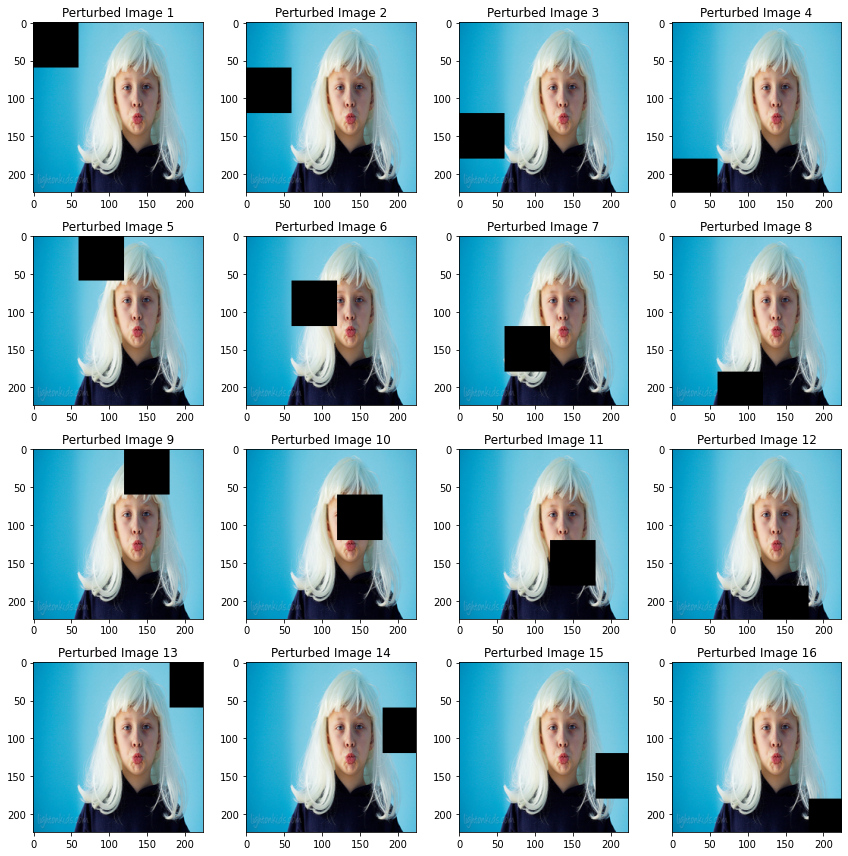

In [26]:
# Choose the index of the original image you want to work with
original_image_index = 0  # Change this index as needed

# Access all the perturbed images for the chosen original image
perturbed_sub_images = perturbed_images_array[original_image_index]

# Create a figure with subplots to display the perturbed images
num_perturbed_images = len(perturbed_sub_images)
num_cols = 4  # Number of columns in the subplot grid
num_rows = (num_perturbed_images + num_cols - 1) // num_cols  # Calculate the number of rows

# Set up the subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 12))

# Iterate through the perturbed images and display them
for i, perturbed_image in enumerate(perturbed_sub_images):
    row = i // num_cols
    col = i % num_cols
    ax = axes[row, col]
    
    ax.imshow(perturbed_image)
    ax.set_title(f'Perturbed Image {i+1}')

# Hide any remaining empty subplots
for i in range(num_perturbed_images, num_rows * num_cols):
    row = i // num_cols
    col = i % num_cols
    fig.delaxes(axes[row, col])

# Adjust layout and display the figure
plt.tight_layout()
plt.show()

In [6]:
images = np.load('/project/validating_attribution_techniques/abid/data/ground_saliency_images/images_2_fixed.npy', allow_pickle=True)

# Guided GradCAM

In [93]:
import torch
import torchvision.models as models
from captum.attr import GuidedGradCam
# from gradcam import GradCAM

# Load your model
# model = models.resnet50(pretrained=True)
# model.eval()

# Load an example image and preprocess it
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

image = Image.fromarray(images[0])
tensor = transform(image).unsqueeze(0)  # Add a batch dimension
gpu_reference_tensor = next(model_gpu.parameters())
tensor_gpu_grad = tensor.type_as(gpu_reference_tensor)


guided_gradcam = GuidedGradCam(model_gpu, target_layer)


guided_gradcam_attr = guided_gradcam.attribute(tensor_gpu_grad, 387)
# guided_gradcam_attr = guided_gradcam_attr.detach().cpu().numpy().squeeze()
guided_gradcam_attr = np.transpose(guided_gradcam_attr.detach().cpu().numpy().squeeze(), (1,2,0))

# # Combine GradCAM and Guided Backprop to get Guided GradCAM
# guided_gradcam_attr = heatmap * guided_backprop_attr


In [94]:
guided_gradcam_attr.shape

(224, 224, 3)

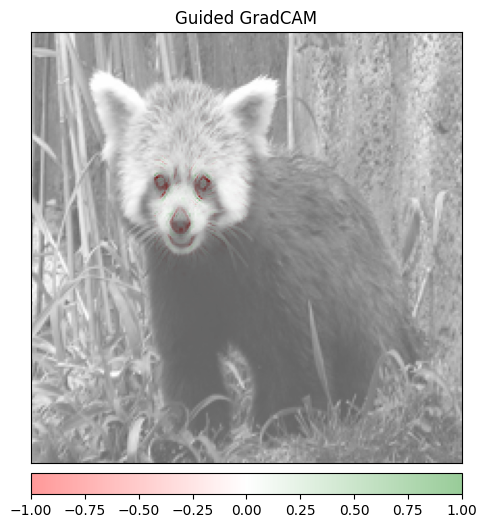

In [95]:
_ = viz.visualize_image_attr(guided_gradcam_attr, images[0], method="blended_heat_map", sign = "all", alpha_overlay = 0.4, show_colorbar=True, 
                          title="Guided GradCAM", use_pyplot = True)

# Saliency

In [131]:
import torch
import torchvision.models as models
from captum.attr import LayerGradCam
# from gradcam import GradCAM

# Load your model
# model = models.resnet50(pretrained=True)
# model.eval()

# Load an example image and preprocess it
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

image = Image.fromarray(images[0])
tensor = transform(image).unsqueeze(0)  # Add a batch dimension
gpu_reference_tensor = next(model_gpu.parameters())
tensor_gpu_grad = tensor.type_as(gpu_reference_tensor)

layer_gradcam = LayerGradCam(model_gpu, target_layer)


layer_gradcam_attr = layer_gradcam.attribute(tensor_gpu_grad, 387)
# guided_gradcam_attr = guided_gradcam_attr.detach().cpu().numpy().squeeze()
layer_gradcam_attr = layer_gradcam_attr.detach().cpu().numpy().squeeze()

# # Combine GradCAM and Guided Backprop to get Guided GradCAM
# guided_gradcam_attr = heatmap * guided_backprop_attr


In [132]:
# layer_gradcam_attr = layer_gradcam_attr.cpu().squeeze(0).squeeze(0)  # Remove unnecessary dimensions

# Convert the PyTorch tensor to a NumPy array
# layer_gradcam_attr_np = layer_gradcam_attr.numpy()

# Reshape the NumPy array to the desired shape (H, W, C)
# H, W, C = layer_gradcam_attr_np.shape[0], layer_gradcam_attr_np.shape[1], 1
# layer_gradcam_attr_np = layer_gradcam_attr_np.reshape((H, W, C))

In [133]:
layer_gradcam_attr_np.shape

(7, 7, 1)

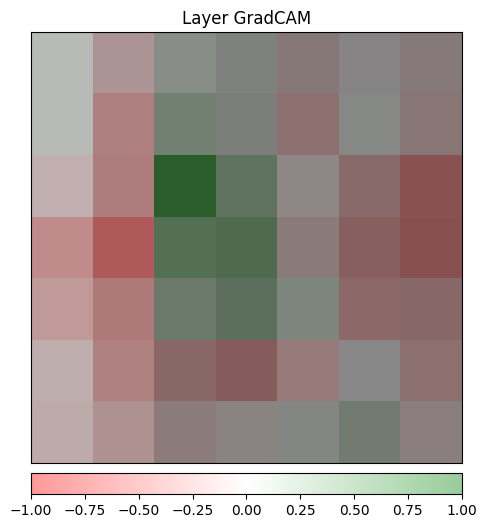

In [134]:
_ = viz.visualize_image_attr(layer_gradcam_attr_np, images[0], method="blended_heat_map", sign = "all", alpha_overlay = 0.4, show_colorbar=True, 
                          title="Layer GradCAM", use_pyplot = True)

In [146]:
guided_gradcam_attr = guided_gradcam_attr[0] # Extract the slice

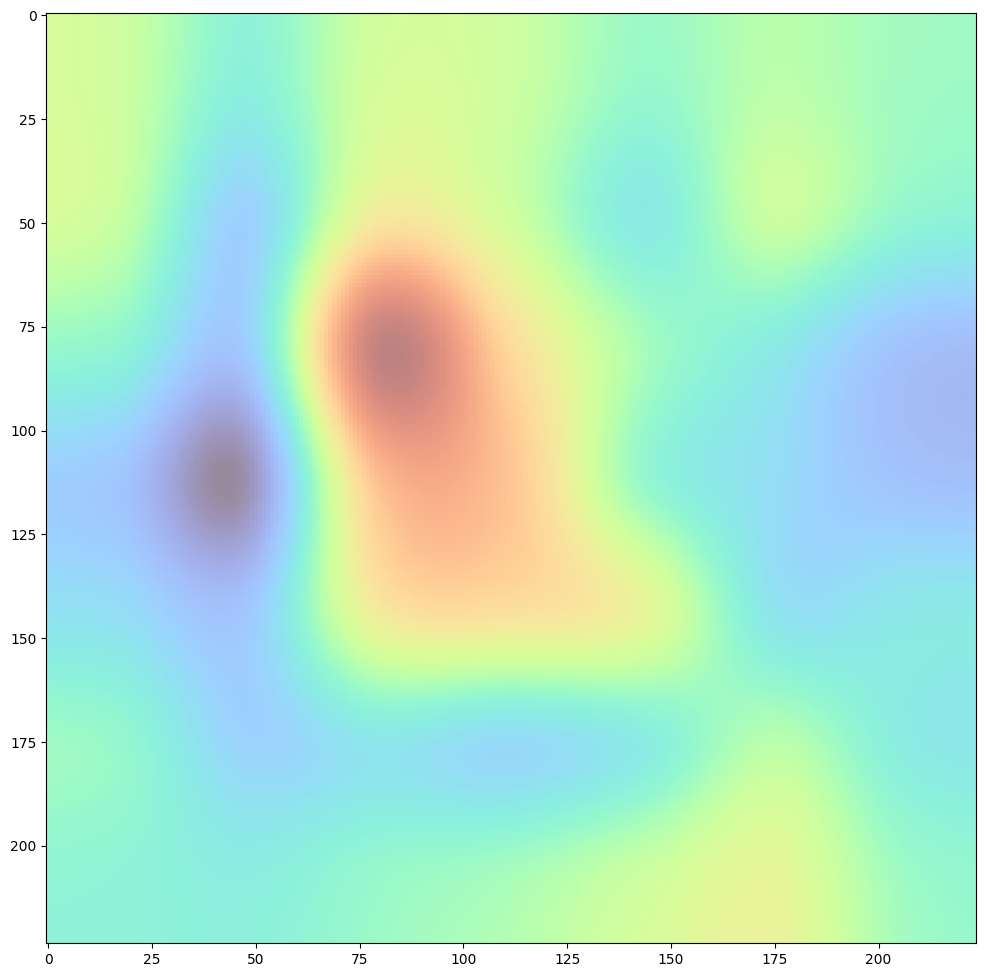

In [106]:

fig, axes = plt.subplots(ncols=1, nrows=1)

fig.set_figwidth(12)
fig.set_figheight(80)
visualize_saliency_overlay(axes, Image.fromarray((images[0])), layer_gradcam_attr);

In [ ]:
fig, ax = plt.subplots(1, 1, figsize = (15, 5))
with torch.no_grad():
  output_grad = model_gpu(tensor_gpu_grad)
  class_grad = torch.argmax(output_grad).item()
  prob_grad = torch.softmax(output_grad, dim=1)[0, class_grad].item()

for i in range(1):
    heatmap = saliency_map(tensor_gpu_grad, guided_gradcam_attr)
    ax[i].imshow(heatmap, cmap='turbo', alpha=0.8)
    ax[i].set_title(f"Guided GradCAM - Class: {idx2label[243]}({prob_grad*100:.2f}%)")
    ax[i].axis('off')  # Turn off the axis
fig.show()
# fig.savefig("/project/validating_attribution_techniques/shardul/NSS/Initial.png")

In [79]:
# Create a LayerGradCam object
layer_grad_cam = LayerGradCam(model_gpu, target_layer)  # The layer you want to visualize

In [80]:
# Get the top predicted class index
with torch.no_grad():
    outputs = model_gpu(tensor)
    _, predicted_class = outputs.max(1)

In [91]:
# Compute the GradCAM attribution
attr = layer_grad_cam.attribute(tensor, target=predicted_class)  # Target class index (e.g., 1 for 'dog')
# attr = attr.cpu()
# attr_cpu = attr.detach().cpu().numpy()
print(attr.shape)

torch.Size([1, 1, 10, 10])


In [85]:
##new

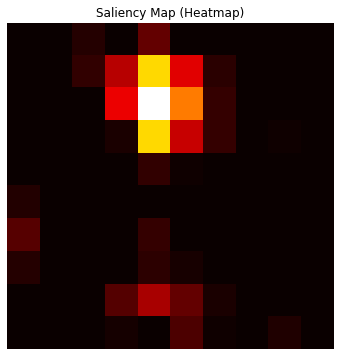

In [86]:
# Convert the attribution tensor to a heatmap image
heatmap = attr.squeeze(0).sum(dim=0).detach().cpu().numpy()
heatmap = np.maximum(heatmap, 0)  # Remove negative values
heatmap /= heatmap.max()  # Normalize

# Create a grayscale heatmap plot
plt.figure(figsize=(6, 6))
plt.imshow(heatmap, cmap='hot')
plt.axis('off')
plt.title('Saliency Map (Heatmap)')
plt.show()

Text(0.5, 1.0, 'Class: tensor([243])')

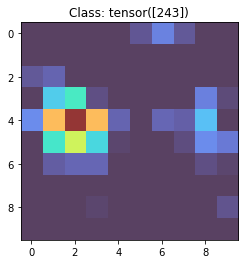

In [90]:
fig, ax = plt.subplots()
heatmap = np.transpose(heatmap.squeeze())
ax.imshow(heatmap, cmap='turbo', alpha = 0.8)
ax.set_title(f"Class: {predicted_class}")

In [49]:
##Old

In [47]:
# Use your custom functions to create the saliency map
grad_heatmap = saliency_map(tensor, attr_cpu)

# Plot the saliency map overlaying the original image
fig, ax = plt.subplots()
ax.imshow(grad_heatmap, cmap='turbo', alpha=0.8)
ax.set_title(f"Saliency Map")

plt.show()

AttributeError: 'numpy.ndarray' object has no attribute 'dim'

In [48]:
with torch.no_grad():
  out = model_gpu(tensor)

In [69]:
def to_gray_image(x):
    x -= x.min()
    x /= x.max() + np.spacing(1)
    x *= 255
    return np.array(x, dtype=np.uint8)

def overlay_heatmap(im, grad):
    # convert PIL Image to numpy array
    img_np = np.array(img)
    # convert gradients to heatmap
    grad = grad.squeeze().detach().numpy()
    grad_img = to_gray_image(grad)
    heatmap = cv2.applyColorMap(grad_img, cv2.COLORMAP_JET)
    heatmap = heatmap[:, :, ::-1] # convert to rgb
    # overlay heatmap on image
    return cv2.addWeighted(img_np, 0.5, heatmap, 0.5, 0)

In [70]:
def attribute(img):
    # preprocess the image
    preproc_img = preprocessing(img)
    # forward propagation to get the model outputs
    inp = preproc_img.unsqueeze(0)
    out = model(inp)    
    # construct LayerGradCam
    layer_grad_cam = LayerGradCam(model, layer)
    # generate attribution map
    _, out_index = torch.topk(out, k=1)
    out_index = out_index.squeeze(dim=1)
    attr = layer_grad_cam.attribute(inp, out_index)
    upsampled_attr = LayerAttribution.interpolate(attr, (img.height, img.width), 'bicubic')
    # generate heatmap
    heatmap = overlay_heatmap(img, upsampled_attr)
    return heatmap, out_index.item()

In [49]:
tensor_cpu = tensor.detach().cpu()
_, out_index = torch.topk(out, k=1)
out_index = out_index.squeeze(dim=1)
attr = layer_grad_cam.attribute(tensor_cpu, out_index)
upsampled_attr = LayerAttribution.interpolate(attr, (img.height, img.width), 'bicubic')
# generate heatmap
heatmap = overlay_heatmap(img, upsampled_attr)

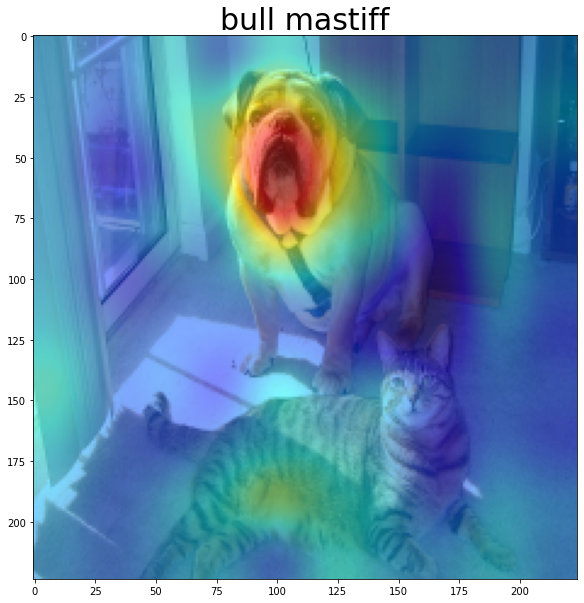

In [53]:
# vis, out_index = attribute(img)
vis, out_index_1 = heatmap, out_index.item()
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
ax.set_title(idx2label[out_index_1], fontsize=30)
plt.imshow(vis)

IndexError: index 473 is out of bounds for dimension 1 with size 1